In [4]:
import os
import pandas as pd
from glob import glob
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# ========== Paths ==========
NEWS_FOLDER = os.path.expanduser("~/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/")
WEEKLY_COUNTS_FOLDER = os.path.expanduser("~/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/weekly_counts_total_coverage/")
OUTPUT_PATH = os.path.join(NEWS_FOLDER, "relative_political_corruption_attention_weekly.csv")

# ========== Define Country-Specific Terms ==========
country_terms = {
    "Netherlands": {
        "political": ["politieke partij", "minister", "kabinet", "regering", "parlement", "burgemeester", "president", "stemfraude", "politiek schandaal"],
        "corruption": ["omkoping", "belangenverstrengeling", "nepotisme", "machtsmisbruik", "corruptie", "witwassen", "steekpenningen", "vriendjespolitiek"]
    },
    "Italy": {
        "political": ["partito politico", "ministro", "governo", "parlamento", "presidente", "elezioni", "scandalo politico"],
        "corruption": ["corruzione", "tangenti", "frode", "abuso di potere", "clientelismo", "finanziamento illecito", "lavaggio di denaro"]
    },
    "Bulgaria": {
        "political": ["политическа партия", "министър", "правителство", "парламент", "президент", "избори", "политически скандал"],
        "corruption": ["корупция", "подкуп", "измама", "злоупотреба с власт", "непотизъм", "пране на пари", "присвояване"]
    },
    "United_Kingdom": {
        "political": ["political party", "minister", "cabinet", "government", "parliament", "prime minister", "elections", "political scandal"],
        "corruption": ["corruption", "bribery", "fraud", "influence peddling", "abuse of power", "cronyism", "embezzlement", "money laundering"]
    },
    "France": {
        "political": ["parti politique", "ministre", "gouvernement", "parlement", "président", "élections", "scandale politique"],
        "corruption": ["corruption", "pot-de-vin", "fraude", "abus de pouvoir", "clientélisme", "blanchiment d'argent", "prise illégale d'intérêt"]
    },
    "Sweden": {
        "political": ["politisk parti", "minister", "regering", "riksdag", "statsminister", "val", "politisk skandal"],
        "corruption": ["korruption", "mutor", "bedrägeri", "maktmissbruk", "vänskapskorruption", "penningtvätt", "intressekonflikt"]
    },
    "Serbia": {
        "political": ["politička partija", "ministar", "vlada", "parlament", "predsednik", "izbori", "politički skandal"],
        "corruption": ["korupcija", "mito", "prevara", "zloupotreba položaja", "nepotizam", "pranje novca", "sukob interesa"]
    },
    "Ukraine": {
        "political": ["політична партія", "міністр", "уряд", "парламент", "президент", "вибори", "політичний скандал"],
        "corruption": ["корупція", "хабар", "шахрайство", "зловживання владою", "кумівство", "відмивання грошей", "конфлікт інтересів"]
    },
    "Germany": {
        "political": ["politische Partei", "Minister", "Regierung", "Parlament", "Bundeskanzler", "Wahl", "politischer Skandal"],
        "corruption": ["Korruption", "Bestechung", "Betrug", "Machtmissbrauch", "Vetternwirtschaft", "Geldwäsche", "Amtsmissbrauch"]
 },
    "Hungary": {
        "political": ["politikai párt", "miniszter", "kormány", "parlament", "elnök", "választások", "politikai botrány"],
        "corruption": ["korrupt", "megvesztegetés", "csalás", "hatalommal való visszaélés", "nepotizmus", "pénzmosás", "személyes érdek", "baráti összefonódás"]
    }
}

# ========== Helper ==========
def is_corruption_article(text, political_terms, corruption_terms):
    text = str(text).lower()
    has_political = any(term in text for term in political_terms)
    has_corruption = any(term in text for term in corruption_terms)
    return has_political and has_corruption

# ========== Step 1: Load Weekly Total Counts ==========
weekly_files = glob(os.path.join(WEEKLY_COUNTS_FOLDER, "*_weekly_count.csv"))
print(f"Found {len(weekly_files)} weekly files: {weekly_files}")

weekly_data = []  # <----- Initialize this before the loop!

for path in weekly_files:
    print("Reading:", path)
    country = os.path.basename(path).split("_weekly_count.csv")[0]
    if country == "UK":
        country = "United_Kingdom"

    try:
        df = pd.read_csv(path)
        original_columns = df.columns.tolist()

        # Normalize column names
        columns = [col.strip().lower().replace(" ", "_") for col in original_columns]
        df.columns = columns

        # Detect week & count columns
        week_col = next((col for col in columns if "start" in col or "week" in col), None)
        count_col = next((col for col in columns if "count" in col), None)

        if not week_col or not count_col:
            raise ValueError(f"Missing week or count column. Found: {columns}")

        df["week"] = pd.to_datetime(df[week_col], errors="coerce")
        df = df.rename(columns={count_col: "total_articles"})

        if df["week"].isna().all():
            raise ValueError("All weeks are NaT (date parsing failed)")

        df["country"] = country
        weekly_data.append(df)
        print(f"✅ Loaded: {path} – {len(df)} rows")

    except Exception as e:
        print(f"❌ Skipped: {path} – {e}")

total_weekly_df = pd.concat(weekly_data, ignore_index=True)
total_weekly_df = total_weekly_df.sort_values(["country", "week"])

# ========== Step 2: Filter News Articles and Count Corruption Weekly ==========
news_files = glob(os.path.join(NEWS_FOLDER, "*_news.csv"))
corruption_weekly_data = []

for path in news_files:
    country = os.path.basename(path).split("_news.csv")[0]
    if country == "UK":
        country = "United_Kingdom"

    if country not in country_terms:
        print(f"⚠️ Skipping {country} – no terms defined.")
        continue

    print(f"🔍 Filtering {country}...")

    df = pd.read_csv(path)
    if "dateTime" in df.columns:
        df["dateTime"] = pd.to_datetime(df["dateTime"], errors="coerce")
    elif "dateTimePub" in df.columns:
        df["dateTime"] = pd.to_datetime(df["dateTimePub"], errors="coerce")
    else:
        print(f"⚠️ Skipping {country} – no datetime column")
        continue

    df = df.dropna(subset=["dateTime"])
    df["week"] = df["dateTime"].dt.to_period("W").apply(lambda r: r.start_time)

    political_terms = country_terms[country]["political"]
    corruption_terms = country_terms[country]["corruption"]

    df["is_corruption"] = df["body"].apply(lambda x: is_corruption_article(x, political_terms, corruption_terms))
    df_filtered = df[df["is_corruption"]]

    corruption_weekly = df_filtered.groupby("week").size().reset_index(name="corruption_count")
    corruption_weekly["country"] = country
    corruption_weekly_data.append(corruption_weekly)

corruption_df = pd.concat(corruption_weekly_data)

# ========== Step 3: Merge & Compute Relative Attention ==========

merged = pd.merge(total_weekly_df, corruption_df, on=["week", "country"], how="left")
merged["corruption_count"] = merged["corruption_count"].fillna(0)
merged["relative_attention"] = merged["corruption_count"] / merged["total_articles"]

merged = merged.sort_values(["country", "week"])
merged.to_csv(OUTPUT_PATH, index=False)

print(f"\n✅ Saved: {OUTPUT_PATH}")

# ========== Step 4: Summarize Absolute and Relative Attention Per Country ==========
summary = merged.groupby("country").agg(
    total_articles=("total_articles", "sum"),
    total_corruption_articles=("corruption_count", "sum")
).reset_index()

summary["relative_attention"] = summary["total_corruption_articles"] / summary["total_articles"]
# Save or print
summary_output_path = os.path.join(NEWS_FOLDER, "summary_political_corruption_attention.csv")
summary.to_csv(summary_output_path, index=False)

print(f"✅ Summary saved: {summary_output_path}")

Found 9 weekly files: ['/home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/weekly_counts_total_coverage/Bulgaria_weekly_count.csv', '/home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/weekly_counts_total_coverage/France_weekly_count.csv', '/home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/weekly_counts_total_coverage/Hungary_weekly_count.csv', '/home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/weekly_counts_total_coverage/Italy_weekly_count.csv', '/home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/weekly_counts_total_coverage/Netherlands_weekly_count.csv', '/home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/weekly_counts_total_coverage/Serbia_weekly_count.csv', '/home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/weekly_counts_total_coverage/Sweden_weekly_count.csv', '/home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/weekly_counts_total_cover

/tmp/ipykernel_1614110/3953501199.py:122: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_1614110/3953501199.py:132: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["dateTime"].dt.to_period("W").apply(lambda r: r.start_time)


🔍 Filtering France...


/tmp/ipykernel_1614110/3953501199.py:122: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_1614110/3953501199.py:132: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["dateTime"].dt.to_period("W").apply(lambda r: r.start_time)


🔍 Filtering Hungary...


/tmp/ipykernel_1614110/3953501199.py:122: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_1614110/3953501199.py:132: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["dateTime"].dt.to_period("W").apply(lambda r: r.start_time)


🔍 Filtering Italy...


/tmp/ipykernel_1614110/3953501199.py:122: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_1614110/3953501199.py:132: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["dateTime"].dt.to_period("W").apply(lambda r: r.start_time)


🔍 Filtering Netherlands...


/tmp/ipykernel_1614110/3953501199.py:132: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["dateTime"].dt.to_period("W").apply(lambda r: r.start_time)


🔍 Filtering Serbia...


/tmp/ipykernel_1614110/3953501199.py:132: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["dateTime"].dt.to_period("W").apply(lambda r: r.start_time)


🔍 Filtering Sweden...


/tmp/ipykernel_1614110/3953501199.py:132: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["dateTime"].dt.to_period("W").apply(lambda r: r.start_time)


🔍 Filtering Ukraine...


/tmp/ipykernel_1614110/3953501199.py:132: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["dateTime"].dt.to_period("W").apply(lambda r: r.start_time)


🔍 Filtering United_Kingdom...


/tmp/ipykernel_1614110/3953501199.py:122: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_1614110/3953501199.py:132: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["dateTime"].dt.to_period("W").apply(lambda r: r.start_time)



✅ Saved: /home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/relative_political_corruption_attention_weekly.csv
✅ Summary saved: /home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/summary_political_corruption_attention.csv


In [5]:
OUTPUT_PATH = "/home/akroon/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/relative_political_corruption_attention_weekly.csv"
df = pd.read_csv(OUTPUT_PATH, parse_dates=["week"])
df

# ========== Step 3: Merge & Compute Relative Attention (Monthly Level) ==========
merged["month"] = merged["week"].dt.to_period("M").apply(lambda r: r.start_time)

# Grouping by month and recalculating relative attention at a monthly level
monthly_data = merged.groupby(["month", "country"]).agg(
    total_articles=("total_articles", "sum"),
    corruption_count=("corruption_count", "sum")
).reset_index()

monthly_data["relative_attention"] = monthly_data["corruption_count"] / monthly_data["total_articles"]

/tmp/ipykernel_1614110/639555216.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(countries))  # 'tab10' has 10 distinct colors


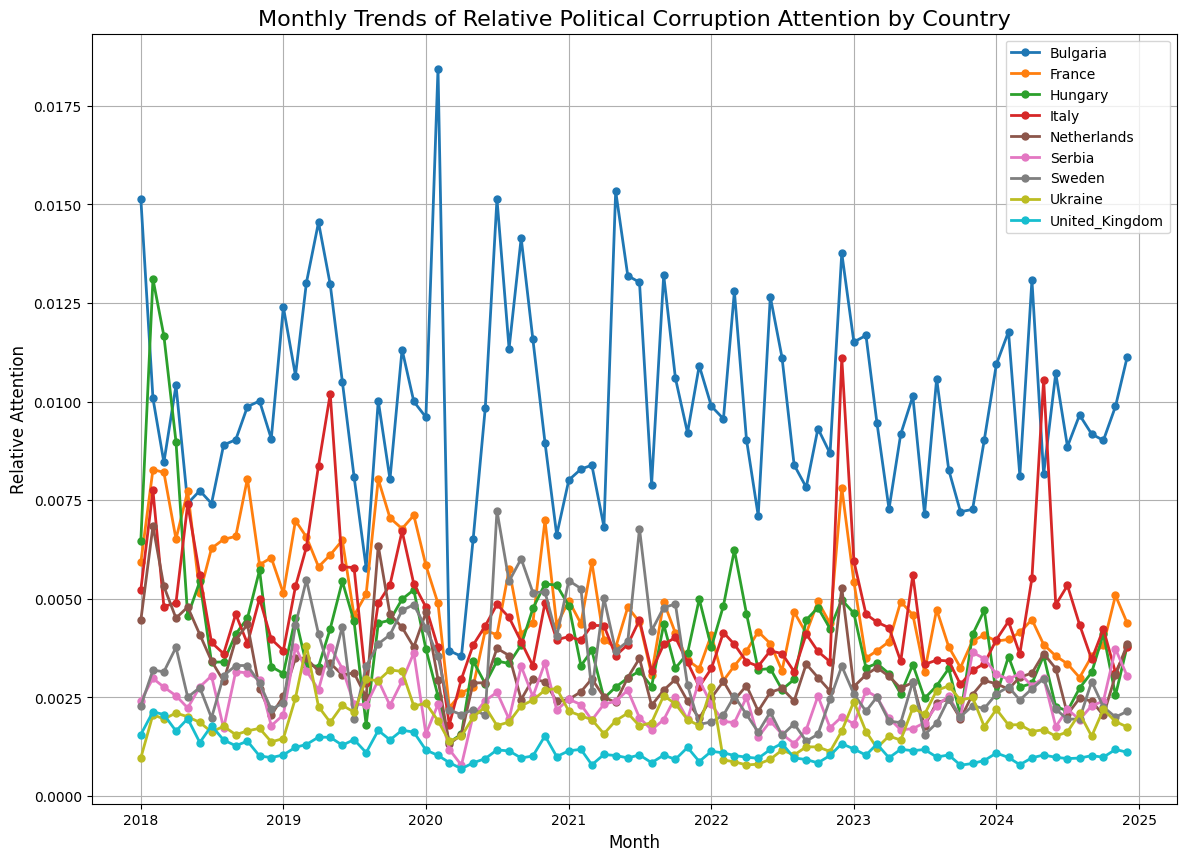

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

countries = sorted(monthly_data["country"].unique())

# Create a colormap with as many distinct colors as countries
cmap = cm.get_cmap('tab10', len(countries))  # 'tab10' has 10 distinct colors

colors = [cmap(i) for i in range(len(countries))]

plt.figure(figsize=(14, 10))

for idx, country in enumerate(countries):
    country_data = monthly_data[monthly_data["country"] == country]
    plt.plot(country_data["month"], country_data["relative_attention"], 
             label=country, 
             linewidth=2, 
             color=colors[idx], 
             marker='o', 
             markersize=5)

plt.title("Monthly Trends of Relative Political Corruption Attention by Country", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Relative Attention", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [9]:
plt.tight_layout()
plt.savefig("monthly_relative_attention.png", dpi=300)  # Save first
plt.show()  # Then display

<Figure size 640x480 with 0 Axes>

In [10]:
summary

,country,total_articles,total_corruption_articles,relative_attention
0,Bulgaria,12651139,124433.0,0.009836
1,France,48447526,230821.0,0.004764
2,Hungary,11688210,43718.0,0.003740
3,Italy,35979919,156371.0,0.004346
4,Netherlands,10439903,31232.0,0.002992
5,Serbia,6569910,15861.0,0.002414
6,Sweden,6398969,20593.0,0.003218
7,Ukraine,17456571,33796.0,0.001936
8,United_Kingdom,313910514,355573.0,0.001133
